## Libraries and variables

In [100]:
import pandas as pd
import numpy as np

# ML Algorithms
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import SGDClassifier, SGDRegressor, LinearRegression, Lasso, Ridge 

# Feature selection
from sklearn.feature_selection import SelectKBest, f_classif, f_regression, SequentialFeatureSelector, RFE
from sklearn.utils import shuffle

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

data_path = '../01_Data/'
file_name_class = '3-2_psp-data_prepro_class.csv'
file_name_regr = '3-2_psp-data_prepro_regr.csv'
file_path_class = data_path + file_name_class
file_path_regr = data_path + file_name_regr

features_categorical = ["country", "PSP", "card", "amount_bucket"]
features_datetime = ["tmsp"]
features_non_numerical = features_categorical + features_datetime

# Due to EDA, the feature country will not be taken into account
features_class = ["amount_sc", "3D_secured", "transaction_hour_sc", "card_Diners", "card_Master", "card_Visa", "PSP_Goldcard", "PSP_Moneycard", "PSP_Simplecard", "PSP_UK_Card"]
target_class = "success"

features_regr = ["amount_sc", "3D_secured", "card_Diners", "card_Master", "card_Visa", "country_Austria", "country_Germany", "country_Switzerland", "PSP_Goldcard", "PSP_Moneycard", "PSP_Simplecard", "PSP_UK_Card", "success_max"]
target_regr = "fee"


## Data load

In [101]:
df = pd.read_csv(file_path_class, index_col=0)
df['tmsp'] = pd.to_datetime(df['tmsp'])
df_class = df[[target_class] + features_class]

df = pd.read_csv(file_path_regr, index_col=0)
df_regr = df[[target_regr] + features_regr]

# Classification

## Feature selection

In [57]:
# Split features from target
X_scaled_class = df_class.drop(target_class, axis=1)
y_class = df_class[target_class]

### Select-K-Best

In [58]:
def get_valuable_features(X, selector) -> pd.DataFrame:
    names = X.columns.values[selector.get_support()]
    scores = selector.scores_[selector.get_support()]
    names_scores = list(zip(names, scores))
    ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
    #Sort the dataframe for better visualization
    ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
    ns_df_sorted.reset_index(inplace=True, drop=True)

    return ns_df_sorted

In [59]:
selector_skb = SelectKBest(f_classif, k=5)
selector_skb.fit_transform(X_scaled_class, y_class)
best_features_df = get_valuable_features(X_scaled_class, selector_skb)
best_features_df

,Feat_names,F_Scores
0,PSP_Goldcard,886.897398
1,amount_sc,378.890655
2,PSP_Simplecard,207.573568
3,3D_secured,177.513104
4,card_Master,33.887798


### Sequential Feature Selector

In [60]:
# Result is not ordered by importance!
def sequ_feat_sel(classifier, n = 5, X=X_scaled_class, y=y_class):
    selector_sfs = SequentialFeatureSelector(classifier, n_features_to_select=n)
    selector_sfs.fit_transform(X, y)

    return selector_sfs.get_feature_names_out()    

In [61]:
sequ_feat_sel(GaussianNB())

array(['amount_sc', '3D_secured', 'transaction_hour_sc', 'card_Diners',
       'card_Master'], dtype=object)

In [62]:
sequ_feat_sel(DecisionTreeClassifier(max_depth=10))

array(['3D_secured', 'card_Diners', 'card_Master', 'card_Visa',
       'PSP_Goldcard'], dtype=object)

### Recursive Feature Selection

In [63]:
# Result is not ordered by importance!
def rec_feat_sel(classifier, n = 5, X=X_scaled_class, y=y_class):
    selector_rfe = RFE(estimator=classifier, n_features_to_select=n, step=1)
    selector_rfe.fit_transform(X, y)

    return selector_rfe.get_feature_names_out()

In [64]:
rec_feat_sel(SGDClassifier())

array(['amount_sc', 'transaction_hour_sc', 'card_Master', 'card_Visa',
       'PSP_Simplecard'], dtype=object)

In [65]:
rec_feat_sel(DecisionTreeClassifier(max_depth=5))

array(['amount_sc', '3D_secured', 'PSP_Goldcard', 'PSP_Moneycard',
       'PSP_Simplecard'], dtype=object)

## PCA (Principal Component Analysis)
Principal components are new variabels that are constructet as linear combinations or mixtures of the initial variables. \
These combinations are done in such a way that new variables are uncorrrelated and most of the information within the initial variables is squeezed into the first components.

All non numerical columns will be removed because PCS uses vectors.\
Column "purchase" will be removed because it's juts for clustering transactions to a purchase.\
Column "fee" will be removed because it depends on the result of "success" and is not available as input for classification \

In [66]:
# Execute PCA
pca = PCA(n_components=X_scaled_class.shape[1])
X_pca_arr = pca.fit_transform(X_scaled_class)
column_names = [f'PC{i+1}' for i in range(X_pca_arr.shape[1])] 
X_pca_df = pd.DataFrame(X_pca_arr, columns=column_names)

In [67]:
# Print explained and cumulative explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = pca.explained_variance_ratio_.cumsum()

print("Explained variance of the individual components:")
for i, var in enumerate(explained_variance):
    print(f"PC {i+1}: {var:.2f}")

print("\nCumulative explained variance:")
for i, cum_var in enumerate(cumulative_variance):
    print(f"After {i+1} PC: {cum_var:.2f}")

Explained variance of the individual components:
PC 1: 0.24
PC 2: 0.24
PC 3: 0.14
PC 4: 0.13
PC 5: 0.12
PC 6: 0.06
PC 7: 0.05
PC 8: 0.02
PC 9: 0.00
PC 10: 0.00

Cumulative explained variance:
After 1 PC: 0.24
After 2 PC: 0.48
After 3 PC: 0.62
After 4 PC: 0.75
After 5 PC: 0.87
After 6 PC: 0.93
After 7 PC: 0.98
After 8 PC: 1.00
After 9 PC: 1.00
After 10 PC: 1.00


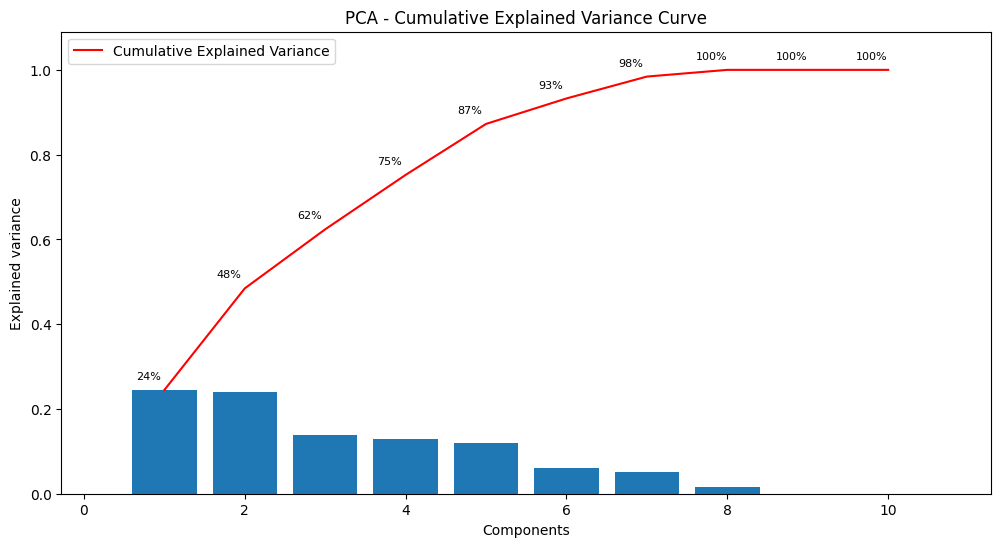

In [68]:
# Explained variance plot
plt.figure(figsize=(12, 6)) 

# Explained variance (bar)
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.ylabel('Explained variance')
plt.xlabel('Components')

# Cumulative explainded varinace (line)
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), cumulative_explained_variance, c='red', label="Cumulative Explained Variance")

# Cumulative variance in percent
offset_y = 0.02  # Offset above line
offset_x = - 0.2
for i, (x_coord, y_coord) in enumerate(zip(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance)):
    plt.text(x_coord + offset_x, y_coord + offset_y, f"{y_coord*100:.0f}%", ha='center', va='bottom', fontsize=8, color='black')

plt.title("PCA - Cumulative Explained Variance Curve")
plt.legend(loc='upper left')

# Ränder einstellen, um Überlappung zu vermeiden
plt.margins(0.09)

plt.show()

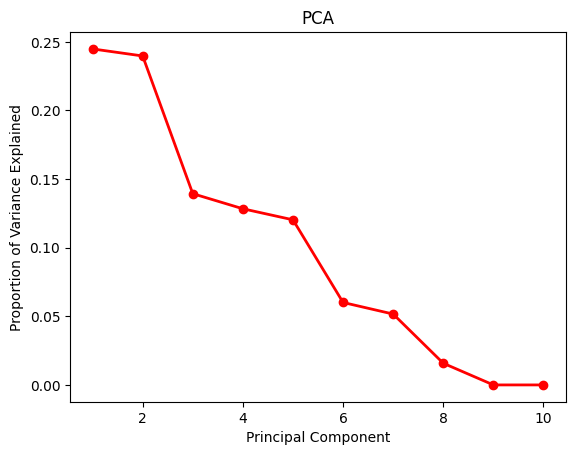

In [69]:
# Plot PCA Variance
pca_values = np.arange(pca.n_components_) + 1
plt.plot(pca_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('PCA')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

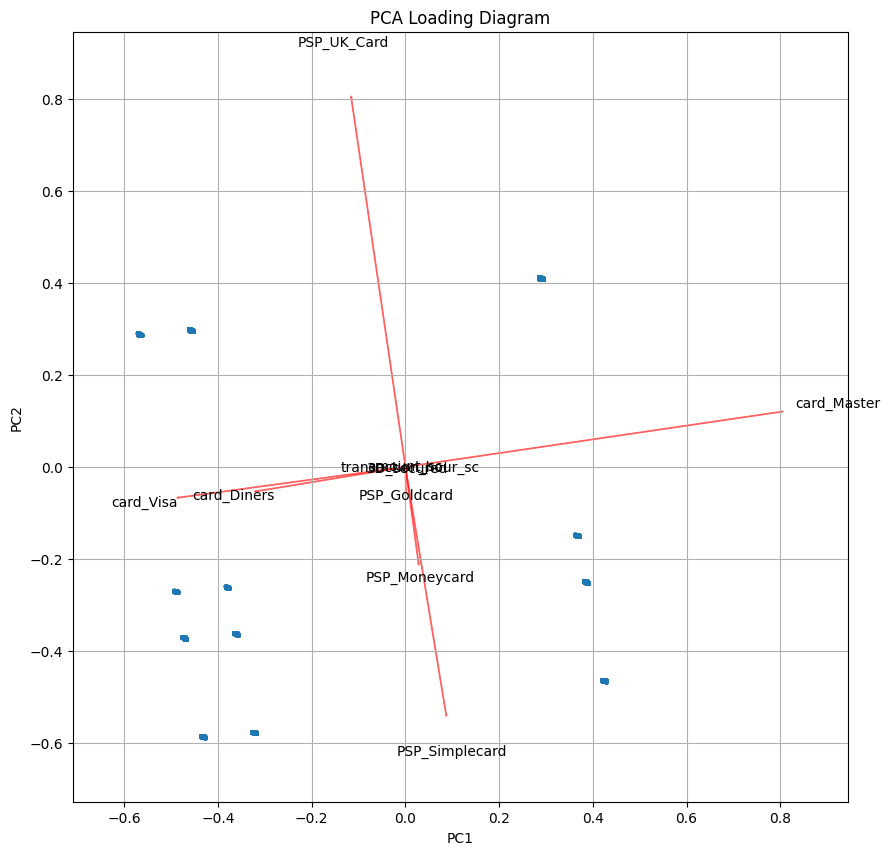

In [70]:
# PCA loading diagram (2 components): All vectors start at the origin and their projected values on components explain how much weight 
# they have on this component. Angles between individual vectors also say something about the correlation between them.
def plot_pca_loading(score, coeff, labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())
    plt.scatter(xs * scalex, ys * scaley, s=5)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color='r', alpha=0.5)
        if labels is None:
            plt.text(coeff[i,0] * 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color='black', ha='center', va='center')
        else:
            plt.text(coeff[i,0] * 1.15, coeff[i,1] * 1.15, labels[i], color='black', ha='center', va='center')

    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()
    
    plt.title(f"PCA Loading Diagram")

plt.figure(figsize=(10, 10)) 
plt.margins(0.1)
plot_pca_loading(X_pca_arr[:,0:2], np.transpose(pca.components_[0:2, :]), list(X_scaled_class.columns)) # Verwenden Sie hier die ursprünglichen Spaltennamen
plt.show()

In [71]:
# Contribution of the original features to the main components
loadings = pd.DataFrame(np.round(pca.components_.T, decimals=2), columns=[f'PC{i+1}' for i in range(len(features_class))], index=features_class)

print(loadings)

                      PC1   PC2   PC3   PC4   PC5   PC6   PC7   PC8   PC9  \
amount_sc           -0.00  0.00 -0.00  0.00  0.00  0.01  0.00  1.00 -0.00   
3D_secured           0.00 -0.00  0.09  0.01  1.00 -0.00 -0.00 -0.00 -0.00   
transaction_hour_sc  0.01 -0.00  0.00 -0.00  0.00  1.00  0.02 -0.01 -0.00   
card_Diners         -0.32 -0.05  0.74 -0.09 -0.07  0.00 -0.00  0.00  0.54   
card_Master          0.80  0.12 -0.09  0.02  0.01 -0.01  0.01  0.00  0.54   
card_Visa           -0.48 -0.07 -0.65  0.07  0.06  0.00 -0.00 -0.00  0.54   
PSP_Goldcard         0.00 -0.05  0.01  0.06  0.00 -0.01  0.86 -0.00 -0.18   
PSP_Moneycard        0.03 -0.21  0.08  0.75 -0.01  0.01 -0.36  0.00 -0.18   
PSP_Simplecard       0.09 -0.54 -0.07 -0.61  0.01  0.00 -0.28  0.00 -0.18   
PSP_UK_Card         -0.12  0.80 -0.02 -0.21  0.01  0.01 -0.22 -0.00 -0.18   

                     PC10  
amount_sc            0.00  
3D_secured           0.00  
transaction_hour_sc  0.00  
card_Diners          0.20  
card_Master 

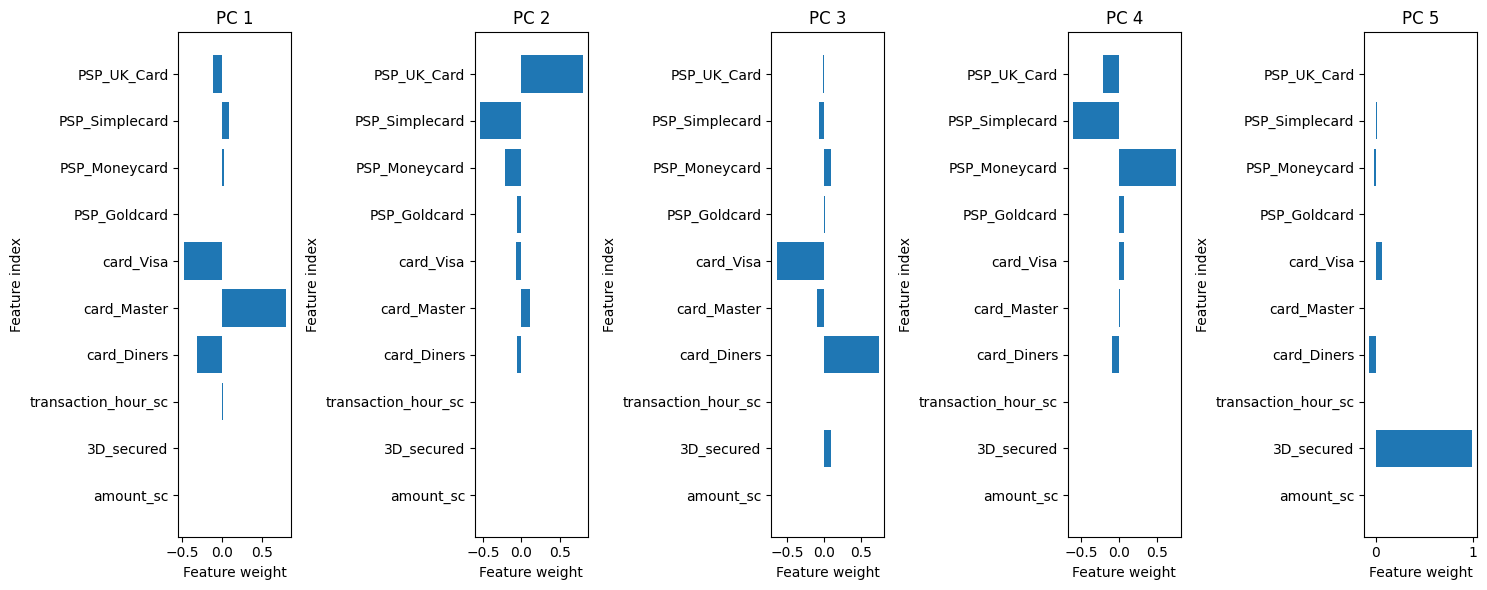

In [72]:
# Plot of contribution of the original features to the main components
feature_weights = pca.components_

n_components_to_plot = 5  # Count of components to plot

plt.figure(figsize=(15, 6))
for i in range(n_components_to_plot):
    plt.subplot(1, n_components_to_plot, i + 1)
    plt.barh(range(len(feature_weights[i])), feature_weights[i])
    plt.title(f'PC {i + 1}')
    plt.xlabel('Feature weight')
    plt.ylabel('Feature index')
    plt.yticks(range(len(features_class)), features_class)
plt.tight_layout()
plt.show()

## Save data for classification

In [93]:
#Data set based on Feature-Selection
features_class_sel = ["success", "amount_sc", "3D_secured", "card_Master", "PSP_Goldcard", "PSP_Simplecard", "card_Diners" ]
df_class_feat_sel = df_class[features_class_sel]
df_class_feat_sel.to_csv(data_path + '4-1_psp-data_feateng_featsel_class.csv')

In [74]:
#Data set based on PCB
df_class_pcb = X_pca_df.drop(["PC8", "PC9", "PC10"],axis=1)
df_class_pcb[target_class] = y_class
df_class_pcb.to_csv(data_path + '4-1_psp-data_feateng_pcb_class.csv')

In [75]:
#Dataset based on almost all columns
df_class.to_csv(data_path + '4-1_psp-data_feateng_all_class.csv')

# Regression

## Feature Selection

In [102]:
# Split features from target
X_scaled_regr = df_regr.drop(target_regr, axis=1)
y_regr = df_regr[target_regr]

### Select-K-Best

In [103]:
selector_skb_regr = SelectKBest(f_regression, k=5)
selector_skb_regr.fit_transform(X_scaled_regr, y_regr)
best_features_df = get_valuable_features(X_scaled_regr, selector_skb_regr)
best_features_df

,Feat_names,F_Scores
0,PSP_Goldcard,34075.171626
1,success_max,15609.330549
2,PSP_Simplecard,11546.892575
3,PSP_Moneycard,845.949943
4,PSP_UK_Card,140.449181


### Sequential Feature Selector

In [104]:
sequ_feat_sel(LinearRegression(), 5, X_scaled_regr, y_regr)

array(['card_Visa', 'PSP_Goldcard', 'PSP_Moneycard', 'PSP_Simplecard',
       'success_max'], dtype=object)

In [105]:
sequ_feat_sel(SGDRegressor(), 5, X_scaled_regr, y_regr)

array(['card_Visa', 'PSP_Goldcard', 'PSP_Simplecard', 'PSP_UK_Card',
       'success_max'], dtype=object)

### Recursive Feature Selection

In [107]:
# Result is not ordered by importance!
def rec_feat_sel_regr(classifier, n = 5, X=X_scaled_regr, y=y_regr):
    selector_rfe = RFE(estimator=classifier, n_features_to_select=n, step=1)
    selector_rfe.fit(X, y)

    return selector_rfe.get_feature_names_out()

In [108]:
rec_feat_sel_regr(LinearRegression())

array(['card_Diners', 'card_Master', 'card_Visa', 'PSP_Simplecard',
       'PSP_UK_Card'], dtype=object)

In [109]:
rec_feat_sel_regr(SGDRegressor())

array(['country_Switzerland', 'PSP_Goldcard', 'PSP_Simplecard',
       'PSP_UK_Card', 'success_max'], dtype=object)

## Save data for regression

In [110]:
#Data set based on Feature-Selection
features_regr_sel = ["fee", "PSP_UK_Card", "PSP_Goldcard", "PSP_Simplecard", "PSP_Moneycard", "success_max", "card_Visa"]
df_regr_feat_sel = df_regr[features_regr_sel]
df_regr_feat_sel.to_csv(data_path + '4-1_psp-data_feateng_featsel_regr.csv')

In [111]:
#Dataset based on almost all columns
df_regr.to_csv(data_path + '4-1_psp-data_feateng_all_regr.csv')